In [1]:
import pandas as pd
from surprise import Reader, Dataset
from surprise import SVD
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [2]:
data = pd.read_csv('data_tp2a.csv')
data = data.loc[:, data.columns != 'Unnamed: 0']
data_dict = {'itemID': list(data.eventoId),
             'userID': list(data.userId),
             'rating': list(data.rating)}
df = pd.DataFrame(data_dict)
print(df.shape)
df.head()

(156, 3)


,itemID,userID,rating
0,25,20,10
1,12,20,10
2,26,17,10
3,9,26,10
4,7,26,5


In [3]:
reader = Reader(rating_scale={0, max(data.rating)})
data = Dataset.load_from_df(df[['userID', 'itemID', 'rating']], reader)

In [4]:
trainset_as_testset, testset = train_test_split(data, test_size=.25)
trainset_as_testset = trainset_as_testset.build_testset()
training_df = pd.DataFrame(trainset_as_testset, columns=['userID','itemID','rating'])
trainset = Dataset.load_from_df(df[['userID', 'itemID', 'rating']], reader)

In [5]:
param_grid = {'n_epochs': [1, 10, 50], 
              'lr_all': [0.85, 0.10, 0.11, 0.12],
              'reg_all': [0.01, 0.005, 0.003, 0.0001]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=6, refit=True)

gs.fit(trainset)

train_error = accuracy.rmse(gs.test(trainset_as_testset), verbose=False)
test_error = accuracy.rmse(gs.test(testset), verbose=False)

print(gs.best_params['rmse'])
print('Traning error (RMSE): {}'.format(train_error))
print('Test error (RMSE): {}'.format(test_error))

{'n_epochs': 1, 'lr_all': 0.12, 'reg_all': 0.0001}
Traning error (RMSE): 1.2747045289896823
Test error (RMSE): 1.666508886815301


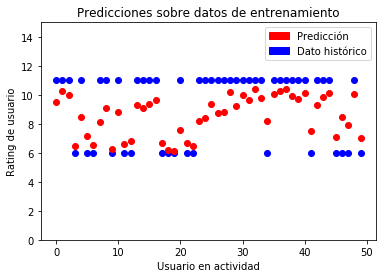

In [9]:
%matplotlib inline
training_pred_df = training_df.copy()
for i in range(len(trainset_as_testset[0:50])):
    training_pred_df.loc[i, 'rating'] = gs.predict(trainset_as_testset[0:50][i][0], trainset_as_testset[0:50][i][1])[3]
    
f, ax = plt.subplots(1)
plt.plot(training_df.index.values[0:50], training_df[0:50]['rating'], 'bo', 
         training_df.index.values[0:50], training_pred_df[0:50]['rating'], 'ro')
ax.set_title('Predicciones sobre datos de entrenamiento')
ax.set_ylim(ymin=0, ymax=15)
ax.set_xlabel('Usuario en actividad')
ax.set_ylabel('Rating de usuario')
red_patch = mpatches.Patch(color='red', label='Predicción')
blue_patch = mpatches.Patch(color='blue', label='Dato histórico')
plt.legend(handles=[red_patch, blue_patch])
plt.show(f)

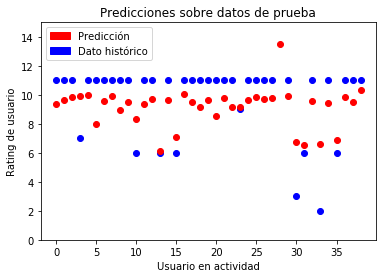

In [10]:
test_df = pd.DataFrame(testset, columns=['usuario','evento','rating'])
prediction_df = pd.DataFrame(testset, columns=['usuario','evento','rating'])
for i in range(len(testset[0:50])):
    prediction_df.loc[i, 'rating'] = gs.predict(testset[0:50][i][0], testset[0:50][i][1])[3]
    
f, ax = plt.subplots(1)
plt.plot(test_df.index.values[0:50], test_df[0:50]['rating'], 'bo', 
         test_df.index.values[0:50], prediction_df[0:50]['rating'], 'ro')
ax.set_ylim(ymin=0, ymax=15)
ax.set_title('Predicciones sobre datos de prueba')
ax.set_xlabel('Usuario en actividad')
ax.set_ylabel('Rating de usuario')
red_patch = mpatches.Patch(color='red', label='Predicción')
blue_patch = mpatches.Patch(color='blue', label='Dato histórico')
plt.legend(handles=[red_patch, blue_patch])
plt.show(f)

In [8]:
eventos = [20, 12, 7, 40, 41]
usuario = 27

def get_eventos_recommendation(usuario, eventos):
    ordered_dict = {}
    for evento in eventos:
        a = gs.predict(usuario, evento)
        ordered_dict[evento] = round(a[3], 2)
    return sorted(ordered_dict.items(), key=lambda kv: kv[1], reverse=True)[:3]

get_eventos_recommendation(usuario, eventos)

[(7, 9.06), (20, 8.39), (41, 8.27)]